In [38]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from models import HorseNet, HorseshoeRegression, HorseshoeGLM
from Layer_classes_clean import MeanFieldHorseshoeLayer_Ghosh, MeanFieldHorseshoeLayer_Ullrich
from train_test import train_wrap, test
from torchvision import datasets, transforms
from objectives import regression_objective, poisson_objective, binary_classification_objective, multiclass_classification_objective
from utils import plot_weights, prune_model, compare_models, compare_shrinkage_rates

class Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Ensure (N, 1) shape
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def plot_vars(model):
    for i, layer in enumerate(model.layers):
        #if isinstance(layer, MeanFieldHorseshoeLayer_Post_Activation):
        print(f"Layer {i} weights:")
        #print(layer.w_mu_q.data)  # This should show zeroed-out weights
        plt.hist(layer.w_logvar.exp().data.numpy().flatten(), bins=100)
        plt.show()
        
def plot_local_shrinkage(model):
    for i, layer in enumerate(model.layers):
        #if isinstance(layer, MeanFieldHorseshoeLayer_Post_Activation):
        print(f"Layer {i} weights:")
        #print(layer.w_mu_q.data)  # This should show zeroed-out weights
        plt.hist(layer.z_mu.data.numpy().flatten(), bins=100)
        plt.show()
        
def plot_global_shrinkage(model):
    for i, layer in enumerate(model.layers):
        #if isinstance(layer, MeanFieldHorseshoeLayer_Post_Activation):
        print(f"Layer {i} weights:")
        #print(layer.w_mu_q.data)  # This should show zeroed-out weights
        plt.hist(layer.s_mu.data.numpy().flatten(), bins=100)
        plt.show()

In [ ]:
# Define a simple dataset for testing if you like
class SimpleDataset(Dataset):
    def __init__(self, num_samples=100):
        # Sample from a bivariate standard normal distribution
        x1 = torch.randn(num_samples, 1)  # ~ N(0,1)
        x2 = torch.randn(num_samples, 1)  # ~ N(0,1)
        
        # Define the function based on a 2D Gaussian-like structure
        y = torch.exp(-0.5 * (x1**2 + x2**2))  # Bivariate Gaussian density

        # Stack into a single tensor for shuffling
        dataset = torch.cat((x1, x2, y), dim=1)

        # Shuffle the dataset
        shuffled_indices = torch.randperm(num_samples)
        dataset = dataset[shuffled_indices]

        # Extract shuffled x1, x2, y
        self.x1 = dataset[:, 0].view(-1, 1)
        self.x2 = dataset[:, 1].view(-1, 1)
        self.y = dataset[:, 2].view(-1, 1)

    def __len__(self):
        return len(self.x1)

    def __getitem__(self, idx):
        x_input = torch.cat([self.x1[idx], self.x2[idx]], dim=0)
        return x_input, self.y[idx]

## LINEAR REGRESSION

In [2]:
np.random.seed(42)
n, p = 10000, 100
X = np.random.randn(n, p).astype(np.float32)  # Ensure dtype is compatible with PyTorch
beta_true = np.zeros(p)
beta_true[:5] = 10.
beta_true[5:20] = 2.
y = (X @ beta_true + np.random.randn(n)).astype(np.float32)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Ensure (N, 1) shape
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


batch_size = 64  # You can adjust this
train_dataset = RegressionDataset(X_train, y_train)
test_dataset = RegressionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

lm_model = HorseshoeRegression(y_train, X_train, iter=2000, intercept=False, ab=(1, 1))
lm_results = lm_model.fit()

In [ ]:
bnn_HS_linreg = HorseNet(input_dim=100,
                               hidden_dims=[],
                               output_dim=1,
                               activation=nn.Identity(),
                               pre_activations=False,
                               tau_0=np.sqrt(1e-12),
                               prune=True)


optim_HS_linreg = torch.optim.Adam(bnn_HS_linreg.parameters(), lr=0.001, eps=1e-2)

train_options = {
    "epochs": 1000,
    "track": True,
    "classification": False,
    "p": 2.0,
    "mc_sample": False,
    "cosine_annealing": True,
    "device": "cpu"
}

results_HS_linreg = train_wrap(model = bnn_HS_linreg, 
                    optimizer = optim_HS_linreg,
                    train_loader = train_loader,
                    N=n,
                    objective=regression_objective,
                     **train_options)



It seems that number of epochs control sparsity more than the size of $\tau_0$. The more epochs, the more weights get a high $\kappa$ value similar to the linear regression

In [ ]:
models = {
    "BNN (p=2)": bnn_HS_linreg
}

#compare_models(models, lm_results, X_test, y_test, test_loader, link="identity")
compare_shrinkage_rates(models, lm_results)

In [ ]:
from utils import plot_training_progress
plot_training_progress(results_HS_linreg['kl_history'][100:], results_HS_linreg['loss_history'][100:], results_HS_linreg['neg_elbo_history'][100:], 10000, "")


In [ ]:
plot_weights(bnn_HS_linreg)

In [ ]:
test(bnn_HS_linreg, test_loader, classification=False, deterministic=False)
prune_model(bnn_HS_linreg, threshold=0.25)
test(bnn_HS_linreg, test_loader, classification=False, deterministic=False)

## LOGISTIC REGRESSION

In [20]:
# 1️⃣ Generate synthetic data
np.random.seed(42)
n, p = 10000, 100
X = np.random.randn(n, p).astype(np.float32)  # Ensure dtype is compatible with PyTorch
beta_true = np.zeros(p)
beta_true[:5] = 10.
beta_true[5:20] = 2.


# Compute logits: X @ beta + noise
eta = X @ beta_true + np.random.randn(n).astype(np.float32)

# Apply sigmoid function to get probabilities
Ey = (1 / (1 + np.exp(-eta))).astype(np.float32)  # Sigmoid function
#Ey = np.log(Ey / (1 - Ey))  # Logit function

y = np.random.binomial(1, Ey).astype(np.float32) 

# 2️⃣ Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


batch_size = 64  # You can adjust this
train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

glm_model = HorseshoeGLM(y_train, X_train, iter=2000, intercept=False, ab=(1, 1), link='logit')
glm_results = glm_model.fit()

In [ ]:
bnn_HS_logit = HorseNet(input_dim=100,
                            hidden_dims=[],
                            output_dim=1,
                            activation=nn.Sigmoid(),
                            pre_activations=False,
                            tau_0=np.sqrt(1e-12))

optim_HS_logit = torch.optim.Adam(bnn_HS_logit.parameters(), lr=0.001, eps=1e-4)

train_options_logit = {
    "epochs": 50,
    "track": True,
    "p": 2.0,
    "link": "logit",
    "mc_sample": False,
    "cosine_annealing": False,
    "device": "cpu"
}

results_HS_logit = train_wrap(model = bnn_HS_logit, 
                    optimizer = optim_HS_logit,
                    train_loader = train_loader,
                    N=n,
                    objective=binary_classification_objective,
                     **train_options_logit)


In [ ]:
def test_binary(model, test_loader, classification=False, deterministic=True, device='cpu'):
    if deterministic:
        model.eval()
    else:
        model.train()
        
    test_loss = 0
    correct = 0

    with torch.no_grad():  # Ensures gradients are not computed
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            if classification:
                # Apply sigmoid to convert logits to probabilities
                probs = torch.sigmoid(output)  
                
                # Compute BCE loss
                loss_fn = nn.BCEWithLogitsLoss()
                test_loss += loss_fn(output, target).sum().item()  

                # Convert probabilities to binary predictions
                pred = (probs > 0.5).float()
                correct += pred.eq(target.view_as(pred)).sum().item()
            else:
                test_loss += nn.MSELoss(reduction="sum")(output, target).item()

        test_loss /= len(test_loader.dataset)

    if classification:
        print('Test loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        return pred
    else:
        print('Test loss (MSE): {:.4f}\n'.format(test_loss))

preds = test_binary(bnn_HS_logit, test_loader, classification=True, deterministic=True)

In [ ]:
models = {
    "BNN": bnn_HS_logit
}

compare_models(models, glm_results, X_test, y_test, test_loader, link="logit")
compare_shrinkage_rates(models, glm_results)

In [30]:
test_binary(bnn_HS_logit, test_loader, classification=True, deterministic=False)
prune_model(bnn_HS_logit, threshold=1e-2)
test_binary(bnn_HS_logit, test_loader, classification=True, deterministic=False)

Test loss: 0.0012, Accuracy: 1940/2000 (97.00%)

Layer 0: Pruned 19.00% weights (19/100)
Test loss: 0.0013, Accuracy: 1928/2000 (96.40%)



## POISSON REGRESSION

In [31]:

# 1️⃣ Generate synthetic Poisson data
np.random.seed(42)
n, p = 100000, 100
X = np.random.randn(n, p).astype(np.float32)  # Ensure dtype is compatible with PyTorch

# Define true coefficients (some strong, some weak signals)
beta_true = np.zeros(p)
beta_true[:5] = 0.5  # Stronger signals
beta_true[5:20] = 0.2  # Weaker signals

# Compute linear predictor (log rate)
eta = X @ beta_true + np.random.randn(n).astype(np.float32) * 0.1  # Small Gaussian noise

# Generate Poisson-distributed response variable
y = np.random.poisson(np.exp(eta)).astype(np.float32)  # Poisson process

# 2️⃣ Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3️⃣ Update dataset class (no change needed)
train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 4️⃣ Fit Bayesian Poisson regression with Horseshoe prior
glm_model = HorseshoeGLM(y_train, X_train, iter=2000, intercept=False, ab=(1, 1), link='log')
glm_results = glm_model.fit()


In [33]:
#from train_test import train_wrap

bnn_HS_poisson = HorseNet(input_dim=100,
                            hidden_dims=[],
                            output_dim=1,
                            activation=nn.Identity(), # We use the log in the objective function
                            pre_activations=False,
                            tau_0=np.sqrt(1e-12))

optim_HS_poisson = torch.optim.Adam(bnn_HS_poisson.parameters(), lr=0.001, eps=1e-4)

train_options = {
    "epochs": 50,
    "track": True,
    "classification": False,
    "p": 2.0,
    "mc_sample": False,
    "cosine_annealing": True,
    "device": "cpu"
}


results_HS_poisson = train_wrap(model = bnn_HS_poisson, 
                    optimizer = optim_HS_poisson,
                    train_loader = train_loader,
                    N=n,
                    objective=poisson_objective,
                     **train_options)


/Users/augustarnstad/Library/CloudStorage/OneDrive-UniversitetetiOslo/UiO/HS_bnn/Horsehoe_BNN/Layer_classes_clean.py:421: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - 0.5 * D * torch.log(torch.tensor(zs**2, device=self.w_mu_q.device)) \
/Users/augustarnstad/Library/CloudStorage/OneDrive-UniversitetetiOslo/UiO/HS_bnn/Horsehoe_BNN/Layer_classes_clean.py:433: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lambda_a_prior = torch.tensor(lambda_a_prior, dtype=torch.float32, device=device)


Epoch 10: Negative ELBO = -2.138606
Epoch 20: Negative ELBO = -2.148503
Epoch 30: Negative ELBO = -2.149275
Epoch 40: Negative ELBO = -2.149314
Epoch 50: Negative ELBO = -2.149668


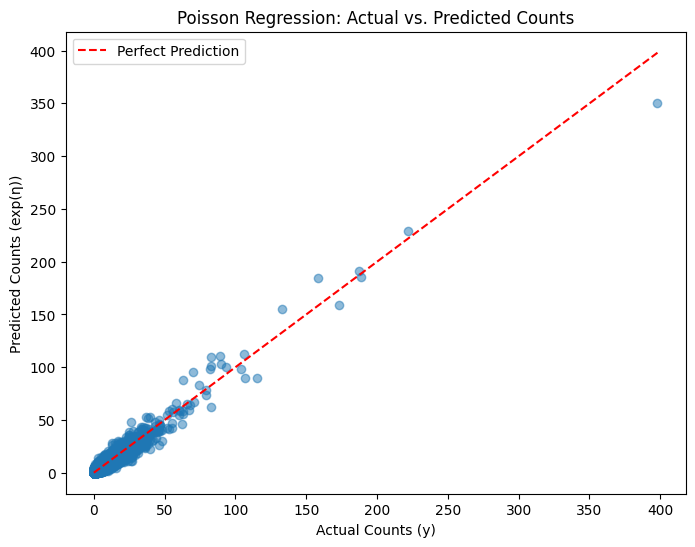

In [34]:
def test_poisson(model, test_loader, deterministic=True, device='cpu'):
    if deterministic:
        model.eval()
    else:
        model.train()
        
    test_loss = 0
    mse_loss = 0  # Track mean squared error
    total_samples = 0

    loss_fn = nn.PoissonNLLLoss(log_input=True)  # Poisson loss

    with torch.no_grad():  # No gradients needed during testing
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # Model outputs log-rate η (not exponentiated)

            # Compute Poisson NLL loss
            test_loss += loss_fn(output, target).sum().item()
            
            # Convert log-rate to mean prediction: E[Y | X] = exp(η)
            predicted_counts = torch.exp(output)

            # Compute MSE between actual and predicted counts
            mse_loss += nn.MSELoss()(predicted_counts, target).item()
            
            total_samples += len(target)

    test_loss /= total_samples
    mse_loss /= total_samples

    print(f'Test Poisson NLL Loss: {test_loss:.4f}, Test MSE: {mse_loss:.4f}')

def plot_poisson_results(model, test_loader, device="cpu"):
    model.eval()
    
    actual_counts = []
    predicted_counts = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # Model outputs log-rate η

            # Convert log-rate to expected count: E[Y | X] = exp(η)
            predicted = torch.exp(output)

            actual_counts.extend(target.cpu().numpy())
            predicted_counts.extend(predicted.cpu().numpy())

    # Scatter plot: Actual vs. Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_counts, predicted_counts, alpha=0.5)
    plt.xlabel("Actual Counts (y)")
    plt.ylabel("Predicted Counts (exp(η))")
    plt.title("Poisson Regression: Actual vs. Predicted Counts")
    plt.plot([min(actual_counts), max(actual_counts)], 
             [min(actual_counts), max(actual_counts)], 
             color="red", linestyle="--", label="Perfect Prediction")
    plt.legend()
    plt.show()

plot_poisson_results(bnn_HS_poisson, test_loader, device="cpu")

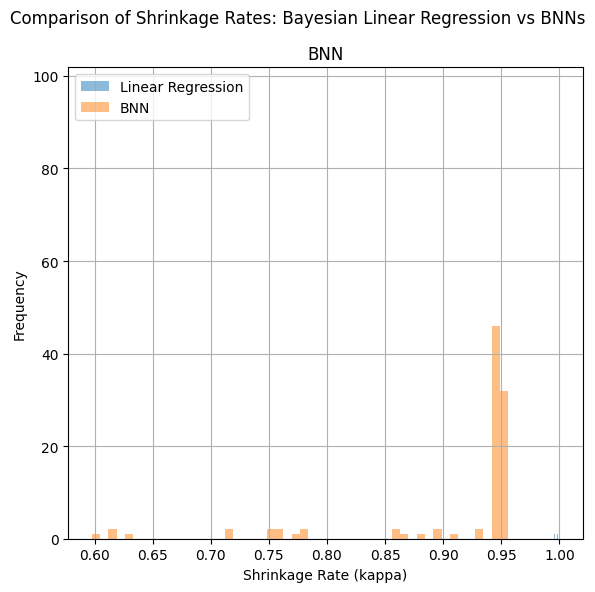

In [35]:
models = {
    "BNN": bnn_HS_poisson
}
compare_shrinkage_rates(models, glm_results)

## MNIST

In [39]:
#MNIST dataset
N=60000
kwargs = {}#{'num_workers': 1, 'pin_memory': True} if FLAGS.cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),lambda x: 2 * (x - 0.5),
                    ])),
    batch_size=64, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(), lambda x: 2 * (x - 0.5),
    ])),
    batch_size=64, shuffle=True, **kwargs)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 3.74MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 238kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:02<00:00, 569kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 298kB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [47]:
bnn_HS_MNIST_Ghosh = HorseNet(input_dim=(28*28), 
                                    hidden_dims=[512, 256, 128], 
                                    output_dim=10,
                                    activation=nn.ReLU(),
                                    pre_activations=True,
                                    tau_0=np.sqrt(1e-12))

bnn_HS_MNIST_Ullrich = HorseNet(input_dim=(28*28), 
                                    hidden_dims=[512, 256, 128], 
                                    output_dim=10,
                                    activation=nn.ReLU(),
                                    pre_activations=False,
                                    tau_0=np.sqrt(1e-12))

optimizer_HS_Ghosh = torch.optim.Adam(bnn_HS_MNIST_Ghosh.parameters(), lr=0.0001, eps=1e-4)

optimizer_HS_Ullrich = torch.optim.Adam(bnn_HS_MNIST_Ullrich.parameters(), lr=0.0001, eps=1e-4)

train_options_MNIST = {
    "epochs": 30,
    "track": True,
    "mc_sample": False,
    "cosine_annealing": False,
    "check_list": [1], #, 10, 50], #, 100, 150, 200],
    "device": "cpu"
}

results_Ghosh = train_wrap(model = bnn_HS_MNIST_Ghosh,
                              optimizer = optimizer_HS_Ghosh, 
                              train_loader = train_loader, 
                              N=N,
                              objective = multiclass_classification_objective,
                              **train_options_MNIST)

results_Ullrich = train_wrap(model = bnn_HS_MNIST_Ullrich,
                              optimizer = optimizer_HS_Ullrich, 
                              train_loader = train_loader, 
                              N=N,
                              objective = multiclass_classification_objective,
                              **train_options_MNIST)



/Users/augustarnstad/Library/CloudStorage/OneDrive-UniversitetetiOslo/UiO/HS_bnn/Horsehoe_BNN/Layer_classes_clean.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lambda_a_prior = torch.tensor(lambda_a_prior, dtype=torch.float32, device=device)


Epoch 10: Negative ELBO = 19.090172
Epoch 20: Negative ELBO = 19.058967
Epoch 30: Negative ELBO = 19.046357


/Users/augustarnstad/Library/CloudStorage/OneDrive-UniversitetetiOslo/UiO/HS_bnn/Horsehoe_BNN/Layer_classes_clean.py:421: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - 0.5 * D * torch.log(torch.tensor(zs**2, device=self.w_mu_q.device)) \
/Users/augustarnstad/Library/CloudStorage/OneDrive-UniversitetetiOslo/UiO/HS_bnn/Horsehoe_BNN/Layer_classes_clean.py:433: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lambda_a_prior = torch.tensor(lambda_a_prior, dtype=torch.float32, device=device)


Epoch 10: Negative ELBO = 19.556757
Epoch 20: Negative ELBO = 19.398296
Epoch 30: Negative ELBO = 19.336699


In [48]:
test(bnn_HS_MNIST_Ullrich, test_loader, classification=True)
# prune_model(bnn_HS_MNIST_Ullrich, threshold=0.1)
# test(bnn_HS_MNIST_Ullrich, test_loader, classification=True)

/Users/augustarnstad/Library/CloudStorage/OneDrive-UniversitetetiOslo/UiO/HS_bnn/.venv/lib/python3.9/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test loss: 0.1361, Accuracy: 9584/10000 (95.84%)



In [50]:
torch.save({
    'model_state_dict': bnn_HS_MNIST_Ghosh.state_dict(),
    'optimizer_state_dict': optimizer_HS_Ghosh.state_dict(),
    'kl_history': results_Ghosh['kl_history'],
    'loss_history': results_Ghosh['loss_history'],
    'neg_elbo_history': results_Ghosh['neg_elbo_history'],
    'ratio_history': results_Ghosh['ratio_history'],
    'architecture': [784, 512, 256, 128, 10]
}, "models/Image_classification/bnn_HS_MNIST_Ghosh.pth")


torch.save({
    'model_state_dict': bnn_HS_MNIST_Ullrich.state_dict(),
    'optimizer_state_dict': optimizer_HS_Ullrich.state_dict(),
    'kl_history': results_Ullrich['kl_history'],
    'loss_history': results_Ullrich['loss_history'],
    'neg_elbo_history': results_Ullrich['neg_elbo_history'],
    'ratio_history': results_Ullrich['ratio_history'],
    'architecture': [784, 512, 256, 128, 10]
}, "models/Image_classification/bnn_HS_MNIST_Ullrich.pth")

In [51]:
checkpoint_Ghosh = torch.load("models/Image_classification/bnn_HS_MNIST_Ghosh.pth")
bnn_HS_MNIST_Ghosh = HorseNet(input_dim=784, hidden_dims=[512, 256, 128], output_dim=10, pre_activations=True)
bnn_HS_MNIST_Ghosh.load_state_dict(checkpoint_Ghosh['model_state_dict'])
optim_Ghosh = torch.optim.Adam(bnn_HS_MNIST_Ghosh.parameters(), lr=0.001)
optim_Ghosh.load_state_dict(checkpoint_Ghosh['optimizer_state_dict'])
kl_history_HS_Ghosh = checkpoint_Ghosh['kl_history']
loss_history_HS_Ghosh = checkpoint_Ghosh['loss_history']
neg_elbo_history_HS_Ghosh = checkpoint_Ghosh['neg_elbo_history']


checkpoint_Ullrich = torch.load("models/Image_classification/bnn_HS_MNIST_Ullrich.pth")
bnn_HS_MNIST_Ullrich = HorseNet(input_dim=784, hidden_dims=[512, 256, 128], output_dim=10, pre_activations=False)
bnn_HS_MNIST_Ullrich.load_state_dict(checkpoint_Ullrich['model_state_dict'])
optim_Jeff = torch.optim.Adam(bnn_HS_MNIST_Ullrich.parameters(), lr=0.001)
optim_Jeff.load_state_dict(checkpoint_Ullrich['optimizer_state_dict'])
kl_history_HS_Ullrich = checkpoint_Ullrich['kl_history']
loss_history_HS_Ullrich = checkpoint_Ullrich['loss_history']
neg_elbo_history_HS_Ullrich = checkpoint_Ullrich['neg_elbo_history']

/var/folders/2g/tqlxxltj3g10t6vhctfp9j8h0000gn/T/ipykernel_39631/2095859264.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_Ghosh = torch.load("models/Image_c